# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Timothy

Last Name: Murphy

Student ID: 912614348

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3 as sql
import datetime
import geopandas as gpd         
import osmnx as ox              
import shapely.geometry as geom
import os
%matplotlib inline

# set the working directory
cwd = os.getcwd()
os.chdir(cwd)

# allow for full view of output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## sf_data.sqlite: https://drive.google.com/open?id=1tbGLJ3gQkzQnZn4a4YyRSZmWa5SE-Ttc

In [2]:
db = sql.connect("sf_data.sqlite") # connect the given data set
pd.read_sql("SELECT * FROM sqlite_master", db) # master table

,type,name,tbl_name,rootpage,sql
0,table,crime,crime,2,"CREATE TABLE ""crime"" (\n""IncidntNum"" INTEGER,\..."
1,table,noise,noise,35775,"CREATE TABLE ""noise"" (\n""CaseID"" INTEGER,\n ""..."
2,table,parking,parking,35921,"CREATE TABLE ""parking"" (\n""Owner"" TEXT,\n ""Ad..."
3,table,schools,schools,35944,"CREATE TABLE ""schools"" (\n""Name"" TEXT,\n ""Ent..."
4,table,parks,parks,35961,"CREATE TABLE ""parks"" (\n""Name"" TEXT,\n ""Type""..."
5,table,zillow,zillow,35967,"CREATE TABLE ""zillow"" (\n""RegionName"" INTEGER,..."
6,table,mobile_food_permits,mobile_food_permits,36050,"CREATE TABLE ""mobile_food_permits"" (\n""permit""..."
7,table,mobile_food_locations,mobile_food_locations,36060,"CREATE TABLE ""mobile_food_locations"" (\n""locat..."
8,table,mobile_food_schedule,mobile_food_schedule,36079,"CREATE TABLE ""mobile_food_schedule"" (\n""locati..."


In [3]:
pd.read_sql("SELECT * FROM mobile_food_permits", db).head()
# List of all mobile food vendor permits

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,16MFF-0027,APPROVED,F & C Catering,Truck,Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...,1,2016-03-09 12:00:00,2017-03-15 12:00:00
1,13MFF-0102,EXPIRED,Natan's Catering,Truck,Burgers: melts: hot dogs: burritos:sandwiches:...,1,2013-04-12 12:00:00,2014-03-15 12:00:00
2,16MFF-0069,APPROVED,Munch A Bunch,Truck,Cold Truck: packaged sandwiches: pitas: breakf...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
3,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
4,16MFF-0010,REQUESTED,Pipo's Grill,Truck,Tacos: Burritos: Hot Dogs: and Hamburgers,0,None,None


In [4]:
pd.read_sql("SELECT * FROM mobile_food_schedule", db).head()
# Schedules for mobile food vendors

,locationid,permit,DayOfWeek,EndHour,StartHour
0,305727,11MFF-0040,Mo,15,10
1,305727,11MFF-0040,Tu,15,10
2,305727,11MFF-0040,We,15,10
3,305727,11MFF-0040,Th,15,10
4,305727,11MFF-0040,Fr,15,10


In [5]:
pd.read_sql("SELECT * FROM mobile_food_locations", db).head()
# List of all locations where mobile food vendors sell

,locationid,LocationDescription,Address,Latitude,Longitude
0,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532
1,437211,MISSOURI ST: 20TH ST to SIERRA ST (500 - 630),555 MISSOURI ST,37.759304,-122.395902
2,765880,17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299),2222 17TH ST,37.765216,-122.406007
3,765690,CESAR CHAVEZ ST: EVANS AVE to KANSAS ST (2100 ...,2323 CESAR CHAVEZ ST,37.748801,-122.400552
4,751253,FOLSOM ST: 14TH ST to 15TH ST (1800 - 1899),1800 FOLSOM ST,37.767852,-122.416105


In [6]:
# join the food schedule and food permit tables and condition on approved permits
permits_schedule = pd.read_sql(
    """
    SELECT left.permit, left.locationid, Status, right.permit, right.Applicant
    
    FROM mobile_food_schedule AS left 
    
    INNER JOIN mobile_food_permits AS right ON left.permit = right.permit
    
    WHERE Status = 'APPROVED'
    """, db)

In [7]:
permits_schedule = permits_schedule.drop_duplicates() # drop the duplicate rows

In [8]:
ps_counts = permits_schedule.iloc[:,4].value_counts() ; ps_counts[:10] # count and print top 10 mobile vendors

Park's Catering                                                            23
D & T Catering                                                             17
F & C Catering                                                             13
Munch A Bunch                                                              10
Eva's Catering                                                              8
BH & MT LLC                                                                 7
Linda's Catering                                                            7
Golden Catering                                                             5
San Francisco Carts & Concessions, Inc. DBA Stanley's Steamers Hot Dogs     5
Subs on Hubs                                                                4
Name: Applicant, dtype: int64

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

## Question 1: Which year had the largest percentage change in the median price for homes that were sold between the years 2011 - 2015 in San Francisco?

In [9]:
zillow_table = pd.read_sql("SELECT * FROM zillow", db) # query zillow data

In [10]:
# seperate tables by years
# drop NaN, covert date to datetime, filter on date/price of homes, groupby date, calculate % change
zillow_2011 = pd.read_sql("SELECT * FROM zillow WHERE Date LIKE '2011%'", db).dropna().reset_index(drop=True)
zillow_2011["Date"] = pd.to_datetime(zillow_2011["Date"])
zillow_2011p = zillow_2011[["Date","MedianSoldPricePerSqft_AllHomes"]]
zillow_2011p = zillow_2011p.groupby("Date").mean()
zillow_2011p["pct_change"] = zillow_2011p.pct_change()
zillow_2011p.iloc[0,1] = 0
zillow_2011p["cum_pct_change"] = zillow_2011p["pct_change"].cumsum()

# drop NaN, covert date to datetime, filter on date/price of homes, groupby date, calculate % change
zillow_2012 = pd.read_sql("SELECT * FROM zillow WHERE Date LIKE '2012%'", db).dropna().reset_index(drop=True)
zillow_2012["Date"] = pd.to_datetime(zillow_2012["Date"])
zillow_2012p = zillow_2012[["Date","MedianSoldPricePerSqft_AllHomes"]]
zillow_2012p = zillow_2012p.groupby("Date").mean()
zillow_2012p["pct_change"] = zillow_2012p.pct_change()
zillow_2012p.iloc[0,1] = 0
zillow_2012p["cum_pct_change"] = zillow_2012p["pct_change"].cumsum()

# drop NaN, covert date to datetime, filter on date/price of homes, groupby date, calculate % change
zillow_2013 = pd.read_sql("SELECT * FROM zillow WHERE Date LIKE '2013%'", db).dropna().reset_index(drop=True)
zillow_2013["Date"] = pd.to_datetime(zillow_2013["Date"])
zillow_2013p = zillow_2013[["Date","MedianSoldPricePerSqft_AllHomes"]]
zillow_2013p = zillow_2013p.groupby("Date").mean()
zillow_2013p["pct_change"] = zillow_2013p.pct_change()
zillow_2013p.iloc[0,1] = 0
zillow_2013p["cum_pct_change"] = zillow_2013p["pct_change"].cumsum()

# drop NaN, covert date to datetime, filter on date/price of homes, groupby date, calculate % change
zillow_2014 = pd.read_sql("SELECT * FROM zillow WHERE Date LIKE '2014%'", db).dropna().reset_index(drop=True)
zillow_2014["Date"] = pd.to_datetime(zillow_2014["Date"])
zillow_2014p = zillow_2014[["Date","MedianSoldPricePerSqft_AllHomes"]]
zillow_2014p = zillow_2014p.groupby("Date").mean()
zillow_2014p["pct_change"] = zillow_2014p.pct_change()
zillow_2014p.iloc[0,1] = 0
zillow_2014p["cum_pct_change"] = zillow_2014p["pct_change"].cumsum()

# drop NaN, covert date to datetime, filter on date/price of homes, groupby date, calculate % change
zillow_2015 = pd.read_sql("SELECT * FROM zillow WHERE Date LIKE '2015%'", db).dropna().reset_index(drop=True)
zillow_2015["Date"] = pd.to_datetime(zillow_2015["Date"])
zillow_2015p = zillow_2015[["Date","MedianSoldPricePerSqft_AllHomes"]]
zillow_2015p = zillow_2015p.groupby("Date").mean()
zillow_2015p["pct_change"] = zillow_2015p.pct_change()
zillow_2015p.iloc[0,1] = 0
zillow_2015p["cum_pct_change"] = zillow_2015p["pct_change"].cumsum()

In [11]:
# extract cumulative percent change for each year
years = ["2011", "2012", "2013", "2014", "2015"]
values = [zillow_2011p.iloc[-1,-1], 
          zillow_2012p.iloc[-1,-1],
          zillow_2013p.iloc[-1,-1],
          zillow_2014p.iloc[-1,-1],
          zillow_2015p.iloc[-1,-1]]

zillow_pchg = pd.DataFrame({"Pct_Change_PriceHome" : values, "Year" : years})
zillow_pchg = zillow_pchg.set_index("Year")

Text(0.5,0,'Year (2011-2015)')

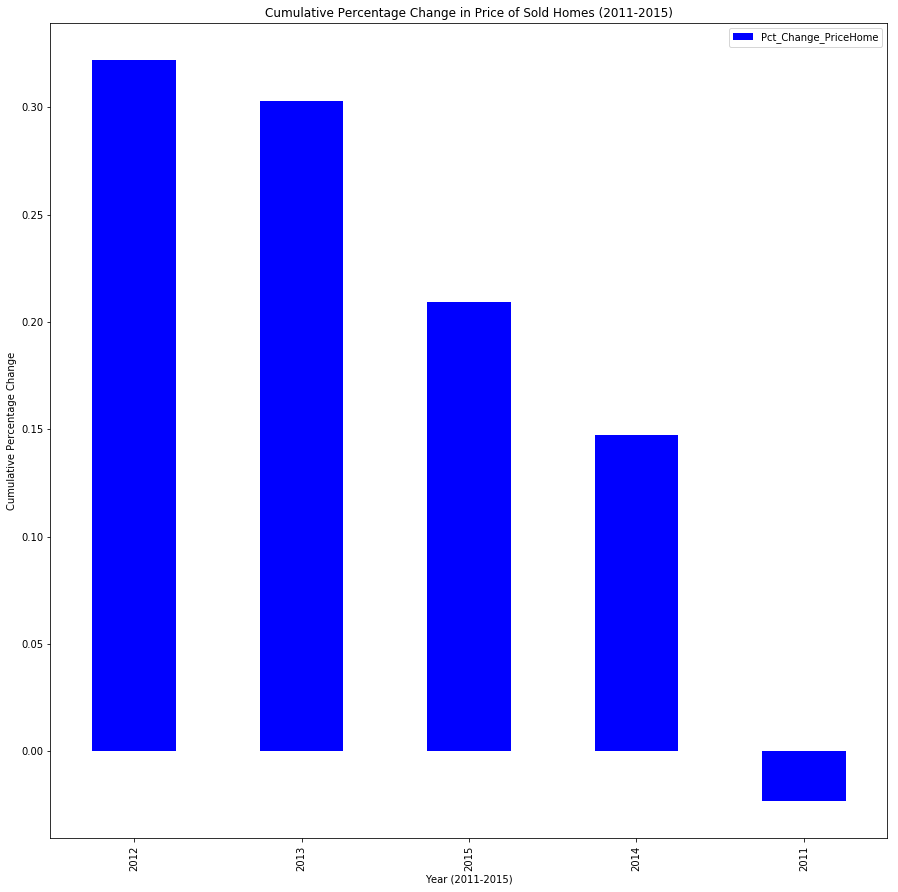

In [12]:
# plot
pct_change_sorted = zillow_pchg.sort_values("Pct_Change_PriceHome", ascending=False)
ax = pct_change_sorted.plot(y = "Pct_Change_PriceHome", kind = "bar", color = "blue", figsize = (15,15))
plt.title("Cumulative Percentage Change in Price of Sold Homes (2011-2015)")
plt.ylabel("Cumulative Percentage Change")
plt.xlabel("Year (2011-2015)")

My goal was to determine which year give the data available in Zillow had the largest percentage change in the median price for homes that were sold between the years 2011 and 2015. I had to break up each year into a separate dataframe where I calculated the percentage change between each lag and then a cumulative sum. This allowed me to determine which year had the most drastic change in price for homes, and this turned out to be the year 2012. I imagine this is due to the recovery from the subprime mortgage crisis that lasted roughly from 2007 to 2010. Therefore, the percentage change in median price of homes is the largest for that year. Even though the mortgage crisis was largely considered to have ended in 2010 the market was still in shock and many home owners were likely not willing to sell their homes for such low prices. 

## Question 2: What is the relationship between the location of mobile food vendors and assault in San Francisco?

In [13]:
# query mobile food vendor location coordinates
vendor_cords = pd.read_sql(
    """
    SELECT Longitude, Latitude 
    
    FROM mobile_food_locations
    """, db)

vendor_geometry = [geom.Point(x) for x in zip(vendor_cords["Longitude"], vendor_cords["Latitude"])] # set vendor point coordinates
vendor_gdf1 = gpd.GeoDataFrame(vendor_cords, geometry = vendor_geometry) # define vendor geo DF
vendor_gdf2 = vendor_gdf1.loc[(vendor_gdf1 != 0).all(axis=1), :] # filter out zero rows
vendor_gdf3 = vendor_gdf2.sample(650) # random sample

crime_assault1 = pd.read_sql(
    """
    SELECT Category, Datetime, lon, lat
    
    FROM crime
    
    WHERE Category = 'ASSAULT'
    """, db)

crime_assault1["Datetime"] = pd.to_datetime(crime_assault1["Datetime"]) # convert date to datetime
crime_geometry = [geom.Point(x) for x in zip(crime_assault1["Lon"], crime_assault1["Lat"])] # set crime point coordinates
crime_gdf1 = gpd.GeoDataFrame(crime_assault1, geometry = crime_geometry) # define crime geo DF
crime_gdf2 = crime_gdf1.sample(650) # random sample

# read SF neighborhood geospatial Shapefile
sf_neighborhoods = gpd.read_file("SF_Find_Neighborhoods/geo_export_8392aa65-4dd6-49eb-b821-062fb9eced8c.shp")

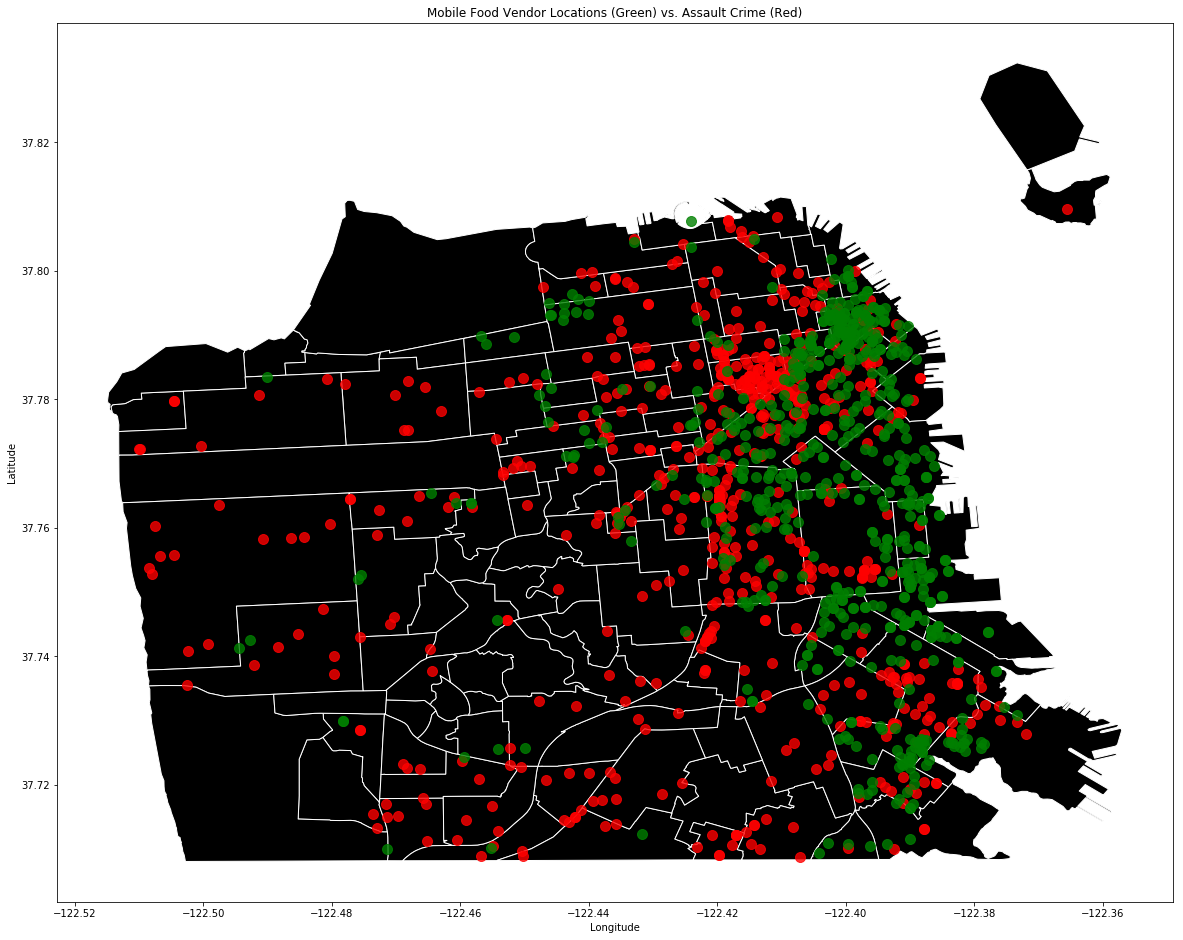

In [14]:
# plot map of SF with dots locating mobile food vendors and reports of assault
# red - crime (assault)
# green - mobile food vendor location
sf_grid1 = sf_neighborhoods.plot(color = "black", edgecolor = "white", figsize = (20,20)) # set up SF grid
crime_gdf2.plot(ax = sf_grid1, color = "red", alpha = 0.8, markersize = 100) # plot assault crime
vendor_gdf3.plot(ax = sf_grid1, color = "green", alpha = 0.8, markersize = 100) # plot vendor locations
plt.title("Mobile Food Vendor Locations (Green) vs. Assault Crime (Red)") # title
plt.ylabel("Latitude") # yaxis
plt.xlabel("Longitude") # xaxis
plt.show()

My goal was to determine whether there is a relationship between the geographic location of assault crimes and the location of mobile food vendors in San Francisco. I was able to pull the longitudinal and latitudinal coordinates for the mobile food vendors as well as the location of reported assault crimes in the city. Using geopandas I was able to place each of these into a geometric data frame. After exporting the Shapefile from the SF Find Neighborhoods link provided I could then plot the two on a map of San Francisco. As you can see from above there appears to be a relationship with assault crime locations and the location of mobile food vendors. If you're knowledgable of the geography of San Francisco at all this makes a lot of sense. The areas with the highest crime rates have the highest foot traffic and density of people (tenderloin, financial district). This is also where most people work in San Francisco so there are more mobile food vendors for when people go to lunch. There is definitely a relationship but I think it is more related to a confounding factor such as population density than anything else. 

## Question 3: What is the relationship between the most and least expensive real estate neighborhoods and the number of schools in that neighborhood of San Francisco?

In [15]:
sf_value = zillow_table.dropna() # drop NaN from zillow table

# query all data from schools
schools = pd.read_sql(
    """
    SELECT * FROM schools
    """, db)

schools["RegionName"] = schools["Address"].str[-5:] # extract zip code from Address field
schools_df1 = schools[["Name", "RegionName"]] # filter down to school name and zip
schools_df2 = schools_df1.groupby("RegionName").count() # count number of schools
schools_df2 = schools_df2.rename(columns = {"Name" : "Num_Schools"}) # rename the columns
schools_df3 = schools_df2.reset_index(level = "RegionName") # reset the index
schools_df3["RegionName"] = schools_df3["RegionName"].astype("str") # convert to object type

sf_value1 = sf_value.groupby("RegionName").mean()  # groupby zip
sf_value2 = sf_value1.reset_index(level = "RegionName") # reset the index
sf_value2["RegionName"] = sf_value2["RegionName"].astype("str") # conver to object type

# redefine data frames for clarity
schools_df = schools_df3
real_estate_df = sf_value2

In [16]:
schools_RE = pd.merge(schools_df, real_estate_df, on = "RegionName") # merge dataframes

In [17]:
schools_RE

,RegionName,Num_Schools,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
0,94102,23,4.124545,771.767609,16.716364,9.389718
1,94103,14,3.694955,772.299804,17.796136,7.584700
2,94105,6,4.251231,994.696386,20.357115,8.240098
3,94107,20,3.610116,807.226175,18.965942,6.569533
4,94109,10,3.775290,815.382592,19.197742,6.254047
5,94110,41,3.081091,785.213186,21.029242,4.745944
6,94112,28,2.403559,523.613843,18.003382,2.916203
7,94114,20,3.289906,904.988180,24.032187,5.096980
8,94115,37,3.510436,831.937807,21.534364,5.168462
9,94116,25,2.360167,610.881575,21.308833,2.471188


In [18]:
num_schools = schools_RE.sort_values("RegionName", ascending=False) # reorder zip to align
RE_value = schools_RE.sort_values("RegionName", ascending=False) # reorder zip to align

Text(0.5,0,'Region')

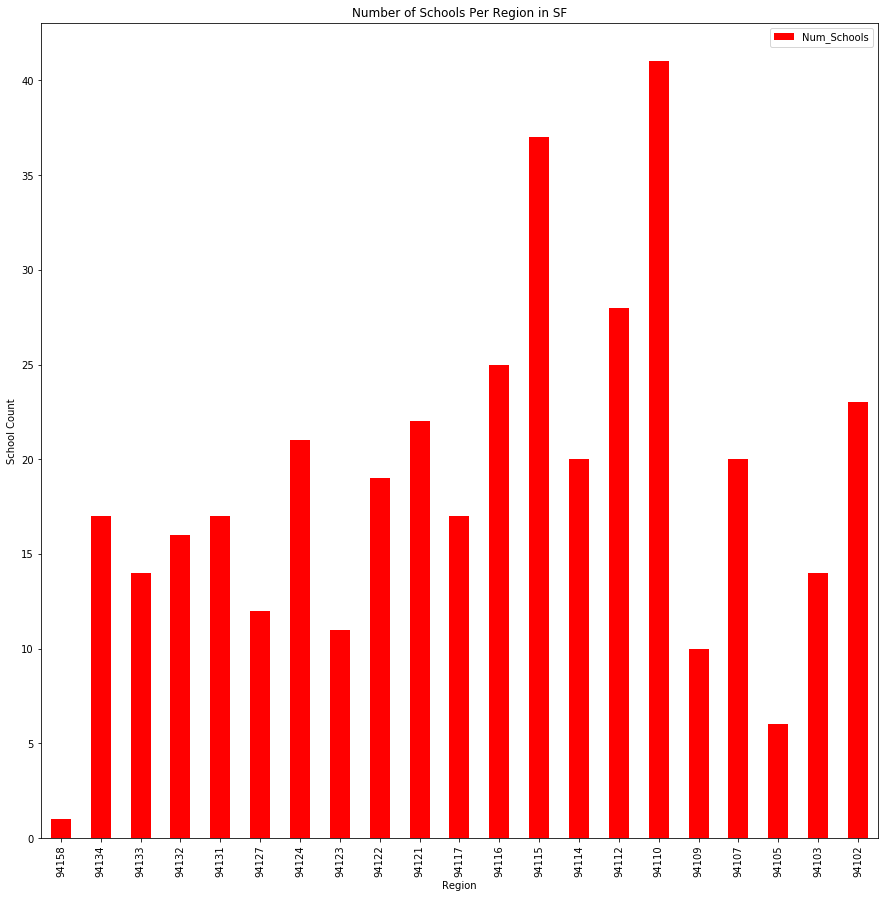

In [19]:
# plot school counts and zip codes
ax1 = num_schools.plot(y = "Num_Schools", x = "RegionName",kind = "bar", color = "red", figsize = (15,15))
plt.title("Number of Schools Per Region in SF") # title
plt.ylabel("School Count") # yaxis
plt.xlabel("Region") # xaxis

Text(0.5,0,'Region')

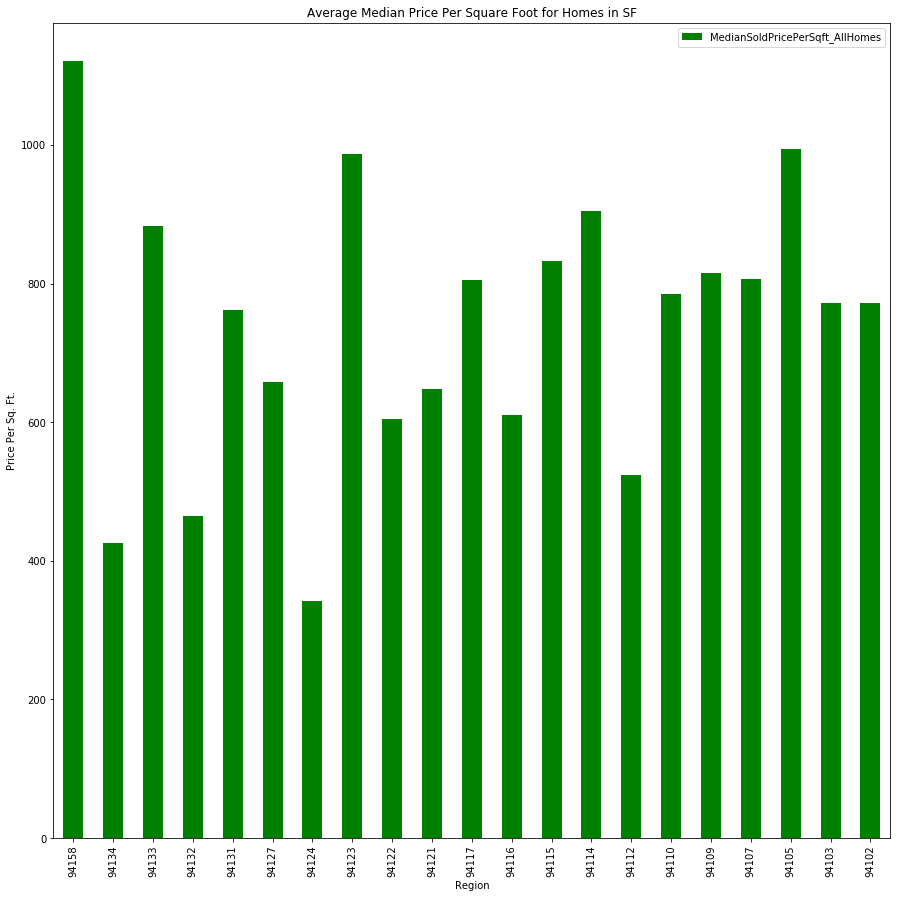

In [20]:
# plot price for homes and zip
ax2 = RE_value.plot(y = "MedianSoldPricePerSqft_AllHomes", x = "RegionName",kind = "bar", color = "green", figsize = (15,15))
plt.title("Average Median Price Per Square Foot for Homes in SF") # title
plt.ylabel("Price Per Sq. Ft.") # yaxis
plt.xlabel("Region") # xaxis

My goal here was to determine if there is a relationship between the most/least expensive neighborhoods and the number of schools in those areas within San Francisco. First I had to extract the zip code from the address provided in the schools table in order to determine the count for number of schools within that region. I then merged the zip codes and their respective counts to the zillow output to able to graph the counts and average median price per square foot for homes sold in that region. Using two separate bar plots I was able to determine that their is not much of a relationship. Yes, some regions such as (94158, 94109, 94105, and 94123) and large differences in the price per square foot of homes and the number of school. However, this is likely due to the fact that these regions are mostly downtown near the financial district where not many families are living. Therefore, I can conclude that there is a limited relationship between the price of homes per square foot in San Francisco and the number of schools in that region. 

## Question 4: What is the relationship between the location of schools and the number of drug/narcotic related crimes reported near that location in San Francisco?

In [21]:
# query all data from schools table
school_cords = pd.read_sql(
    """
    SELECT * FROM schools
    """, db)

school_cords["RegionName"] = school_cords["Address"].str[-5:] # extract zip data from address field
school_cords = school_cords[["Name", "RegionName", "Lon", "Lat"]] # filter 
school_geometry = [geom.Point(x) for x in zip(school_cords["Lon"], school_cords["Lat"])] # set school point coordinates
school_gdf = gpd.GeoDataFrame(school_cords, geometry = school_geometry) # define school geo DF

In [22]:
# query drug/narcotic data from crime table
drug_cords = pd.read_sql(
    """
    SELECT Category, Datetime, lon, lat
    
    FROM crime
    
    WHERE Category = 'DRUG/NARCOTIC'
    """, db)
drug_cords = drug_cords.sample(450) # sample to 450 because very large
drug_geometry = [geom.Point(x) for x in zip(drug_cords["Lon"], drug_cords["Lat"])] # set drug point coordinates
drug_gdf = gpd.GeoDataFrame(drug_cords, geometry = drug_geometry) # define drug geo DF

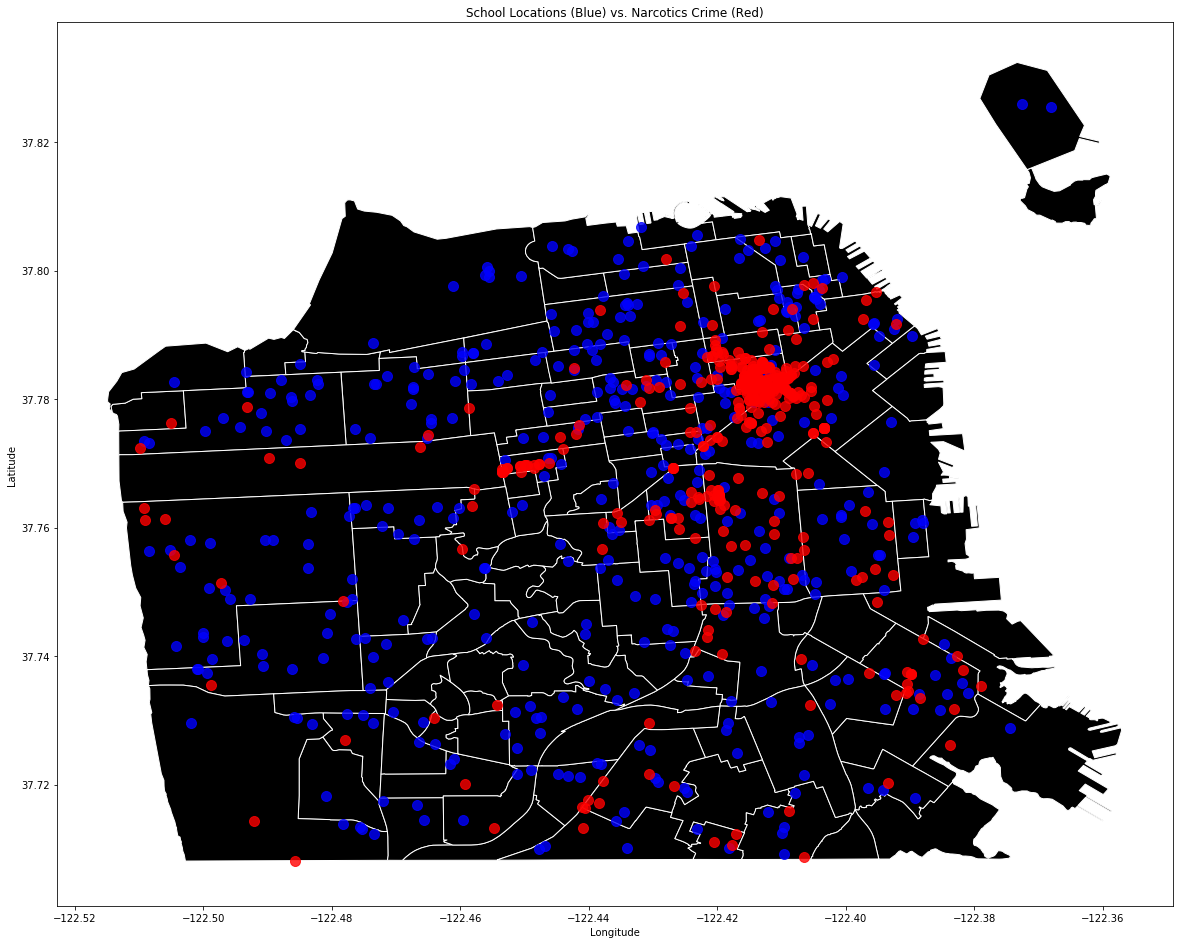

In [23]:
# set up grid
sf_grid2 = sf_neighborhoods.plot(color = "black", edgecolor = "white", figsize = (20,20))
school_gdf.plot(ax = sf_grid2, color = "blue", alpha = 0.8, markersize = 100) # plot school locations
drug_gdf.plot(ax = sf_grid2, color = "red", alpha = 0.8, markersize = 100) # plots drug report locations
plt.title("School Locations (Blue) vs. Narcotics Crime (Red)") # title
plt.ylabel("Latitude") # yaxis
plt.xlabel("Longitude") # xaxis
plt.show()

My goal here was to determine if there is a relationship between the location of schools and the number of drug and narcotics crimes reported in the city of San Francisco. All I needed was to extract the longitude and latitude coordinates for from each table (schools and crimes). For crimes I included a WHERE clause to narrow in on the drug/narcotic type of reports. The total number of schools included in the schools table is 450. So I only included a random sample of 450 crime reports to avoid over plotting the graph and allowing me to more easily assess the relationship. The findings are not surprising, I found that there is not a strong relationship between drug related offenses near schools. This is likely due to the fact that there are more police, parents, and family type neighborhoods unlike downtown. As you can see from the map that there is a heavy concetration of red (indicating drug crime) in the downtown area known as the tenderloin. For the most part this makes a lot of sense due to the heavy concetration of homeless and denser population. 

## Question 5: Is it better to purchase or rent a home in San Francisco between the years 2011-2016 ? 
Price/Rent Ratio: (1-15 BUYERS MARKET, 16-20 RENT/BUY MARKET, 21+ GREAT RENTERS MARKET)

In [24]:
# separate into years
zillow_2011br = zillow_2011.groupby("Date").mean() # group by date
zillow_2011br = zillow_2011br[["PriceToRentRatio_AllHomes"]] # filter

zillow_2012br = zillow_2012.groupby("Date").mean() # group by data
zillow_2012br = zillow_2012br[["PriceToRentRatio_AllHomes"]] # filter

zillow_2013br = zillow_2013.groupby("Date").mean() # group by date
zillow_2013br = zillow_2013br[["PriceToRentRatio_AllHomes"]] # filter

zillow_2014br = zillow_2014.groupby("Date").mean() # group by date
zillow_2014br = zillow_2014br[["PriceToRentRatio_AllHomes"]] # filter

zillow_2015br = zillow_2015.groupby("Date").mean() # group by date
zillow_2015br = zillow_2015br[["PriceToRentRatio_AllHomes"]] # filter

# combine data frames into a list for concatenation 
zillow_years = [zillow_2011br,
                zillow_2012br,
                zillow_2013br,
                zillow_2014br,
                zillow_2015br]

buy_rent_df = pd.concat(zillow_years) # concat
buy_rent_df

,PriceToRentRatio_AllHomes
Date,
2011-01-01,18.270909
2011-02-01,18.626000
2011-03-01,19.375000
2011-04-01,19.482500
2011-05-01,19.841765
2011-06-01,19.449444
2011-07-01,19.103889
2011-08-01,19.238947
2011-09-01,18.570000


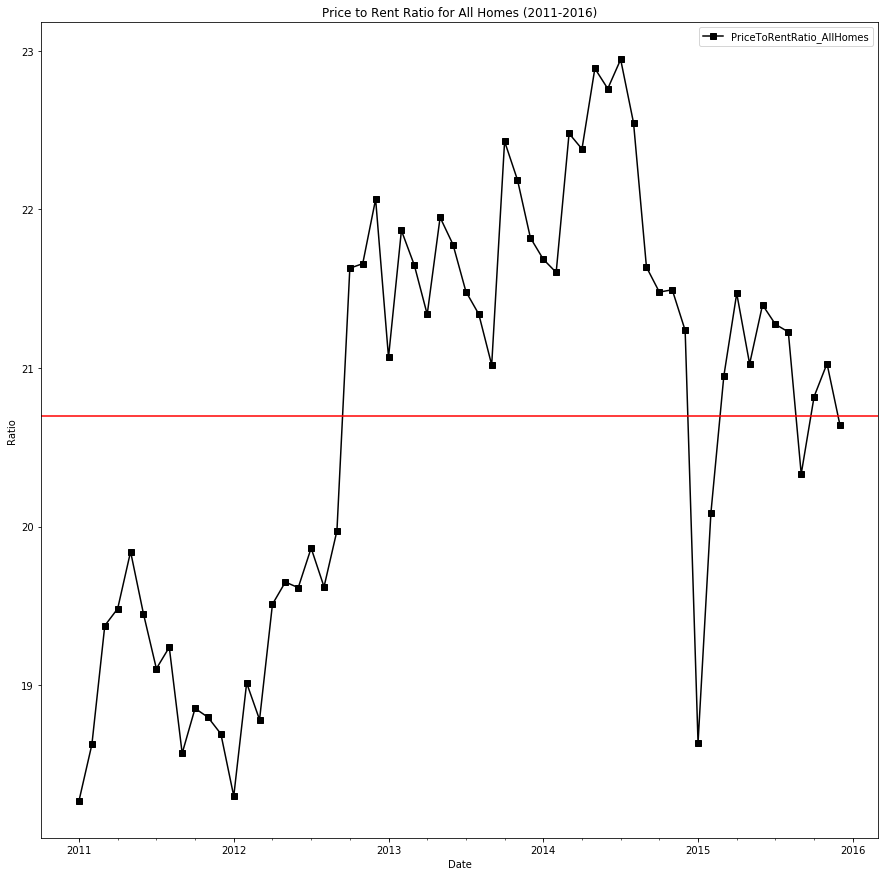

In [25]:
avg_prr = buy_rent_df["PriceToRentRatio_AllHomes"].mean() # average price to rent ratio
buy_rent_df.plot(y = "PriceToRentRatio_AllHomes", marker='s', linestyle='-', color='k',figsize = (15,15)) # plot 
plt.axhline(avg_prr, color = "red") # plot average price to rent ratio
plt.title("Price to Rent Ratio for All Homes (2011-2016)") # title
plt.ylabel("Ratio") # yaxis
plt.xlabel("Date") # xaxis
plt.show()


My goal here was to determine whether it was better to buy or rent real estate in the city of San Francisco for each year between 2011 and 2015. The price to rent ratio is a commonly used economic indicator on whether to buy or rent a property when making a real east valuation. Given the data that I have been given this is a very rough benchmark on a buy/rent decision. Regardless, my findings are interesting, San Francisco has not been a buyers market for a long time. This city is known for having some of the most expensive real estate in the world. Therefore it is not surprising that the price to rent ratio never falls below 18. Typically it is a good indication that you should buy when the price to rent ratio is between 1 and 15. However, between 16-20 it is still a toss up on whether one side gets the better end of the deal. Until the 4th quarter of 2012 the price to rent ratio bounced between 18 and 20. This is when the real estate market was still recovering from the subprime mortgage crisis. Then at the end of 2012 and during 2013/2014 the price to rent ratio sky rockets above the 21 mark making it a great time for renters in the market. When the price of homes increased so much after the housing crisis there is destined to be a correction. In 2015 the price to rent ratio crashed back down to a 4 year low making it a better time for those looking to buy to jump back in the market. Finally, in the year 2015 the market seemed to stabilize between buyers and renters and the price to rent ratio hovered towards the 5 year average of 20-21.  